In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
import matplotlib.pyplot as plt

In [ ]:
def get_noisy_img(img, noise_var):
  noise1 = np.random.normal(scale=np.sqrt(noise_var), size=img.shape)
  img_noisy = np.clip(img.astype(np.float32) + noise1, 0, 255).astype(np.uint8)
  return img_noisy

In [ ]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    height, width = image.shape

    # Generate random noise
    salt_noise = np.random.uniform(0, 1, (height, width)) <= salt_prob
    pepper_noise = np.random.uniform(0, 1, (height, width)) <= pepper_prob

    # Add salt noise
    noisy_image[salt_noise] = 255

    # Add pepper noise
    noisy_image[pepper_noise] = 0

    return noisy_image

In [ ]:
Prytula_orig = cv2.imread('/content/3.jpg').astype('float32')
Trapezna_orig = cv2.imread('/content/4.jpg').astype('float32')

In [ ]:
Prytula_SnP = cv2.imread('/content/3_col_s&p_015_01.jpg').astype('float32')
Prytula_Gauss = cv2.imread('/content/3_col_gaussian_30_60 (2).jpg').astype('float32')
Trapezna_SnP = cv2.imread('/content/trapezna_col_s&p_015_01.jpg').astype('float32')
Trapezna_Gauss = cv2.imread('/content/trapezna_col_gaussian_30_60 (2).jpg').astype('float32')

In [ ]:
def get_UDV(image):
    b, g, r = cv2.split(image)

    U_b, D_b, Vt_b = np.linalg.svd(b)
    U_g, D_g, Vt_g = np.linalg.svd(g)
    U_r, D_r, Vt_r = np.linalg.svd(r)
    return U_b, D_b, Vt_b, U_g, D_g, Vt_g, U_r, D_r, Vt_r

In [ ]:
def k_rank_denoised_image(k, matrices):
    U_b, D_b, Vt_b, U_g, D_g, Vt_g, U_r, D_r, Vt_r = matrices
    U_k_b = U_b[:, :k]
    D_k_b = D_b[:k]
    Vt_k_b = Vt_b[:k, :]
    
    U_k_g = U_g[:, :k]
    D_k_b = D_g[:k]
    Vt_k_g = Vt_g[:k, :]
    
    U_k_r = U_r[:, :k]
    D_k_r = D_r[:k]
    Vt_k_r = Vt_r[:k, :]
    
    compressed_b = U_k_b.dot(np.diag(D_k_b)).dot(Vt_k_b)
    compressed_g = U_k_g.dot(np.diag(D_k_b)).dot(Vt_k_g)
    compressed_r = U_k_r.dot(np.diag(D_k_b)).dot(Vt_k_r)

    approximated = cv2.merge((compressed_b, compressed_g, compressed_r))
    return approximated

In [ ]:
def calculate_psnr(original_image, denoised_image):
    mse = np.mean((original_image - denoised_image) ** 2)  # Calculate mean squared error (MSE)
    max_pixel_value = np.max(original_image)  # Find the maximum pixel value in the original image
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))  # Calculate PSNR
    return psnr

In [131]:
def psnr_plot(image_noised, image_orig):
    k_values = range(5, 100 + 1, 1)
    
    psnr_values = []
    matrices = get_UDV(image_noised)

    for k in k_values:
        denoised_image = k_rank_denoised_image(k, matrices)
        psnr = calculate_psnr(image_orig, denoised_image)
        psnr_values.append(psnr)
    return k_values, psnr_values

24.869792461395264 107


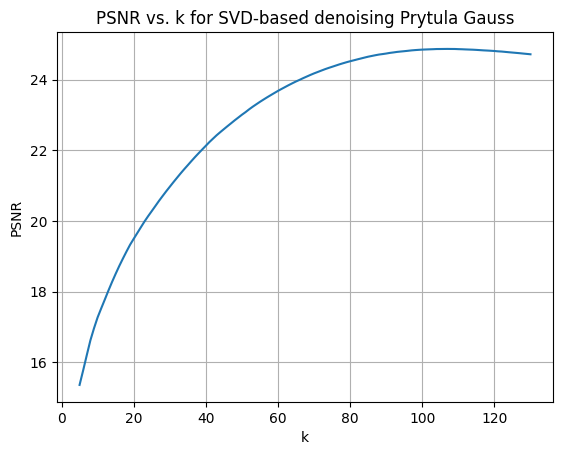

17.467371225357056 26


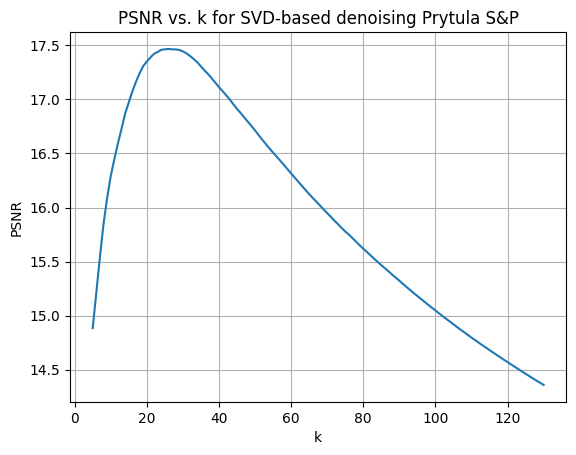

14.734783172607422 55


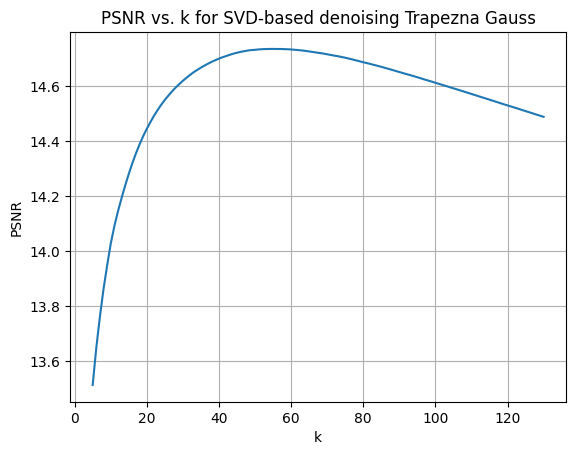

15.52022933959961 23


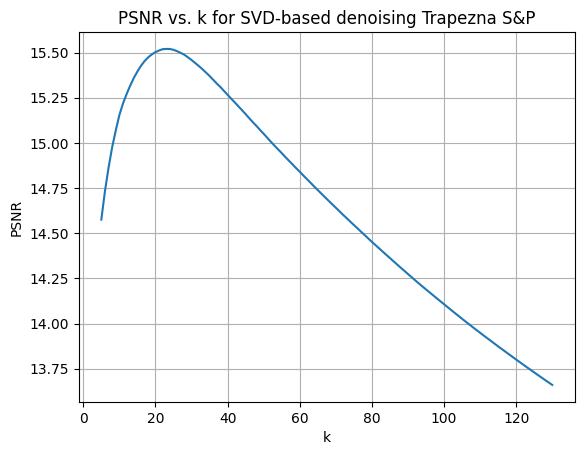

In [134]:
res = psnr_plot(Prytula_Gauss, Prytula_orig)
print(max(res[1]), res[0][res[1].index(max(res[1]))])
plt.plot(res[0], res[1])
plt.xlabel("k")
plt.ylabel("PSNR")
plt.title("PSNR vs. k for SVD-based denoising Prytula Gauss")
plt.grid(True)
plt.show()

res = psnr_plot(Prytula_SnP, Prytula_orig)
print(max(res[1]), res[0][res[1].index(max(res[1]))])
plt.plot(res[0], res[1])
plt.xlabel("k")
plt.ylabel("PSNR")
plt.title("PSNR vs. k for SVD-based denoising Prytula S&P")
plt.grid(True)
plt.show()

res = psnr_plot(Trapezna_Gauss, Trapezna_orig)
print(max(res[1]), res[0][res[1].index(max(res[1]))])
plt.plot(res[0], res[1])
plt.xlabel("k")
plt.ylabel("PSNR")
plt.title("PSNR vs. k for SVD-based denoising Trapezna Gauss")
plt.grid(True)
plt.show()

res = psnr_plot(Trapezna_SnP, Trapezna_orig)
print(max(res[1]), res[0][res[1].index(max(res[1]))])
plt.plot(res[0], res[1])
plt.xlabel("k")
plt.ylabel("PSNR")
plt.title("PSNR vs. k for SVD-based denoising Trapezna S&P")
plt.grid(True)
plt.show()

In [ ]:
def show_denoised_image(image_noised, k):
    matrices = get_UDV(image_noised)
    denoised_image = k_rank_denoised_image(k, matrices)
    # print(f"{image_noised}")
    cv2_imshow(denoised_image)

In [ ]:
show_denoised_image(Prytula_Gauss, 100)
show_denoised_image(Prytula_SnP, 25)
show_denoised_image(Trapezna_Gauss, 58)
show_denoised_image(Trapezna_SnP, 20)